In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import hydra
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

from utils import load_states_from_checkpoint
from data_utils.s2s_dataset import load_jsonl_data, S2S_dataset
from model_utils.create_model import create_model, create_gaussian_diffusion


/home/gcilleru/ProphetNet/AR-diffusion/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fake torch distributed
from torch import distributed as dist
from torch.nn.parallel import DistributedDataParallel

def initialize_distributed():
    if not dist.is_initialized():
        # Initialize the distributed environment
        dist.init_process_group(backend='gloo')  # 'gloo' is suitable for local development

# Call the initialization function
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1' 
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'
initialize_distributed()

# Now you can use distributed functions safely
rank = dist.get_rank()
print(f"Rank {rank} reporting in!")

Rank 0 reporting in!


In [3]:
hydra.initialize(config_path=".")

/tmp/ipykernel_3713284/930210726.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path=".")


hydra.initialize()

In [4]:
config = hydra.compose(config_name="config.yaml")

In [5]:
# CUDA_VISIBLE_DEVICES=6 torchrun --nproc_per_node=1 --nnodes=1 --master_port 29501 generate.py \
# model.name='bert-base-uncased' batch_size=128 \
# exp.name=$FILE_NAME load_step=$STEP \
# data.name=$DATA_NAME data.path=$DATA_PATH tgt_len=32 max_pos_len=32 num_samples=50 \
# intermediate_size=2048 num_attention_heads=8 dropout=0.2 \
# in_channels=128 out_channels=128 time_channels=128 \
# skip_sample=False gen_timesteps=2000 \
# schedule_sampler='uniform' time_att=True att_strategy='txl' load_from_ema=False prediction=True \
# fix_encoder=True model.custom_denoiser=True model.denoiser_layers=1 \


config

config.exp.name="d1_uni"
config.load_step=20000
config.data.name="reverse"
config.data.path="data/raw/sequence"

config.model.name = 'bert-base-uncased'
config.tgt_len=32
config.max_pos_len=512
config.num_samples=1 # how many generations for each sample

config.intermediate_size=2048
config.num_attention_heads=8
config.dropout=0.2
config.in_channels=128
config.out_channels=128
config.time_channels=128

config.skip_sample=False
config.gen_timesteps=2000
config.schedule_sampler='xy_uniform'
config.time_att=True
config.att_strategy='txl'

config.load_from_ema=False
config.prediction=True

# config.fix_encoder=True
config.model.custom_denoiser=False
config.model.denoiser_layers=6

config.batch_size = 128


In [6]:
config.exp.dir = os.path.join(config.exp.root, config.data.name, config.exp.name)
generate_path = os.path.join(config.exp.dir, str(config.load_step))
if config.load_from_ema:
    generate_path += ('_ema_' + str(config.ema_rate))
if config.clip_denoised:
    generate_path += '_clip_denoised_'
if config.infer_self_condition:
    generate_path += '_selfcond_'
if config.skip_sample:
    generate_path += '_skip_'
if config.ddim_sample:
    generate_path += '_ddim_'

if config.schedule_sampler == 'xy_uniform':
    generate_path += ('_xy_' + str(config.gen_timesteps))
else:
    generate_path += ('_un_' + str(config.skip_timestep))

print("Generate path: ", generate_path)
print("Exp dir: ", config.exp.dir)

Generate path:  ./my_output/reverse/d1_uni/20000_xy_2000
Exp dir:  ./my_output/reverse/d1_uni


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 3

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.model.name)
vocab_size = tokenizer.vocab_size

In [9]:
# if config.load_from_ema:
#     eval_model_path = os.path.join(
#         config.exp.dir, 'model', f'ema_{config.ema_rate}_checkpoint-{config.load_step}')
# else:
#     eval_model_path = os.path.join(
#         config.exp.dir, 'model', f'model_checkpoint-{config.load_step}')
# eval_model_path = "data/models/GENIE_ckpt-500w"
eval_model_path = "my_output/recipes/model_xy_l6_fe/model/model_checkpoint-80000"
print("Load model from: ", eval_model_path)

Load model from:  my_output/recipes/model_xy_l6_fe/model/model_checkpoint-80000


In [10]:
diffusion = create_gaussian_diffusion(config)
model = create_model(config, vocab_size)

In [11]:
model_saved_state = load_states_from_checkpoint(eval_model_path, dist.get_rank())
model.load_state_dict(model_saved_state.model_dict)

<All keys matched successfully>

In [12]:
model.to(device)

CrossAttention_Diffusion_LM(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, 

In [13]:
# sample text from random noise
if config.ddim_sample:
    sample_fn = (diffusion.ddim_sample_loop)
else:
    sample_fn = (diffusion.p_sample_loop)

In [14]:
emb_model = model.word_embedding

In [15]:
data_piece = [
    {
        "src": "Baked pizza spaghetti Ingredients: 1 pound spaghetti 1 jar pasta sauce of your choice (usually make my own but went lazy on this) 3 cups Italian cheese 1 bag mini pepperoni Directions: -Cook noodles per box directions to aldente or a bit less since they will bake too -[MASK] -Mix pasta and sauce in pot and dump in greased 9x13 pan -Evenly spread cheese on top and top with the mini pepperoni as many or little as you like. -Bake in 375F oven for half a hour or until cheese is nice and brown",
        "tgt": "In a pan heat sauce with a 1/4 bag pepperoni",
    },
    # {
    #     "src":"34",
    #     "tgt":"34"
    # },
    # {
    #     "src":"44 31",
    #     "tgt":"31 44"
    # },
    # {
    #     "src":"67 99 56",
    #     "tgt":"56 99 67"
    # }
]

dev_dataset = S2S_dataset(data_piece, tokenizer, config)
dev_dataloader = DataLoader(
    dev_dataset, batch_size=config.batch_size, 
    drop_last=False, pin_memory=True, num_workers=config.num_workers, 
    collate_fn=S2S_dataset.get_collate_fn(config)
)

# print len of tokenized src of data_piece[0]
print(len(dev_dataset[0]["src"][0]))

116


In [18]:
import numpy as np
from tqdm import tqdm
from functools import partial

def denoised_fn_round(config, emb_model, text_emb, t):
    down_proj_emb = emb_model.weight  # (vocab_size, embed_dim)

    old_shape = text_emb.shape
    old_device = text_emb.device

    def get_efficient_knn(down_proj_emb, text_emb, dist='l2'):
        if dist == 'l2':
            emb_norm = (down_proj_emb ** 2).sum(-1).view(-1, 1)  # (vocab, 1)
            text_emb_t = torch.transpose(text_emb.view(-1, text_emb.size(-1)), 0, 1)  # (emb_dim, bs*seqlen)
            arr_norm = (text_emb ** 2).sum(-1).view(-1, 1)  # (bs*seqlen, 1)
            # down_proj_emb: (vocab, emb_dim), text_emb_t:(emb_dim, bs*seqlen)
            # a+b automatically broadcasts to the same dimension i.e. (vocab, bs*seqlen)
            dist = emb_norm + arr_norm.transpose(0, 1) - 2.0 * torch.mm(down_proj_emb, text_emb_t) 
            dist = torch.clamp(dist, 0.0, np.inf)  # Limit the value of input to [min, max].
        # Select the smallest distance in the vocab dimension, 
        # that is, select bs*seq_len most likely words from all vocabs.
        topk_out = torch.topk(-dist, k=1, dim=0)

        return topk_out.values, topk_out.indices  # logits, token_id (1, bs*seq_len)

    dist = 'l2'
    if len(text_emb.shape) > 2:
        text_emb = text_emb.reshape(-1, text_emb.size(-1))
    else:
        text_emb = text_emb

    val, indices = get_efficient_knn(down_proj_emb,
                                     text_emb.to(down_proj_emb.device), dist=dist)
    rounded_tokens = indices[0]  # (bs*seq_len,)
    new_embeds = emb_model(rounded_tokens).view(old_shape).to(old_device)

    return new_embeds



In [76]:
# generate 1 sample for each data

# torch.cuda.empty_cache()
each_sample_list = []

for _, batch in enumerate(tqdm(dev_dataloader)):
    with torch.no_grad():
        encoder_hidden_states = model.encoder(
            input_ids=batch['src_input_ids'].to(device), 
            attention_mask=batch['src_attention_mask'].to(device),
        ).last_hidden_state  # [bs, seq_len, hz]

    if config.pred_len:
        with torch.no_grad():
            length_out = model.get_pred_len(
                encoder_hidden_states=encoder_hidden_states,
                src_masks=batch['src_attention_mask'].to(device),
                normalize=True,
            )  # [bs, max_pos_len]
            pred_lengs = length_out.max(-1)[1]  # [bs,], max return tuple(value, indices)

        tgt_attention_mask = []
        for len_item in pred_lengs:
            tgt_attention_mask.append([1] * len_item + [0] * (max(pred_lengs) - len_item))
        tgt_attention_mask = torch.tensor(tgt_attention_mask).long()
        
        input_shape = (
            tgt_attention_mask.shape[0], tgt_attention_mask.shape[1], config.in_channels,
        )
    else:
        pred_lengs, tgt_attention_mask = None, None
        input_shape = (
            batch['src_input_ids'].shape[0], config.tgt_len, config.in_channels,
        )

    model_kwargs = {'src_attention_mask': batch['src_attention_mask'].to(device),
                    'tgt_attention_mask': tgt_attention_mask,
                    'encoder_hidden_states': encoder_hidden_states,}

    sample = sample_fn(
        model,
        input_shape,
        clip_denoised=config.clip_denoised,
        # "Freeze" some parameters for easy recall.
        denoised_fn=partial(denoised_fn_round,
                            config, emb_model.to(device)),
        progress=True,
        model_kwargs=model_kwargs,
        pred_lengs=pred_lengs,
        top_p=-1.0,
    )


    logits = model.get_logits(sample)  # (bs, seq_len, vocab_size)
    sample_id_tensor = torch.argmax(logits, dim=-1)

    
    each_sample_list.extend(tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True))

    print(tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True))

  0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
**************xy_uniform sam

100%|██████████| 1/1 [00:21<00:00, 21.55s/it]

['in a large bowl, combine the oil,, and sugar, and reduce the., the orange and zest, baking powder, honey, cinnamon,']


In [ ]:
samples = []
for sample in diffusion.p_sample_loop_progressive(
                    model,
                    input_shape,
                    noise=None,
                    clip_denoised=config.clip_denoised,
                    denoised_fn=partial(denoised_fn_round,
                            config, emb_model.to(device)),
                    model_kwargs=model_kwargs,
                    device=device,
                    progress=True,
                    top_p=-1.0,
                ):
                    final = sample

In [20]:
model.transformer_blocks[1].attn1.attention_probs.shape

torch.Size([8, 32, 32])

In [21]:
model.transformer_blocks[1].attn2.attention_probs.shape

torch.Size([8, 32, 116])

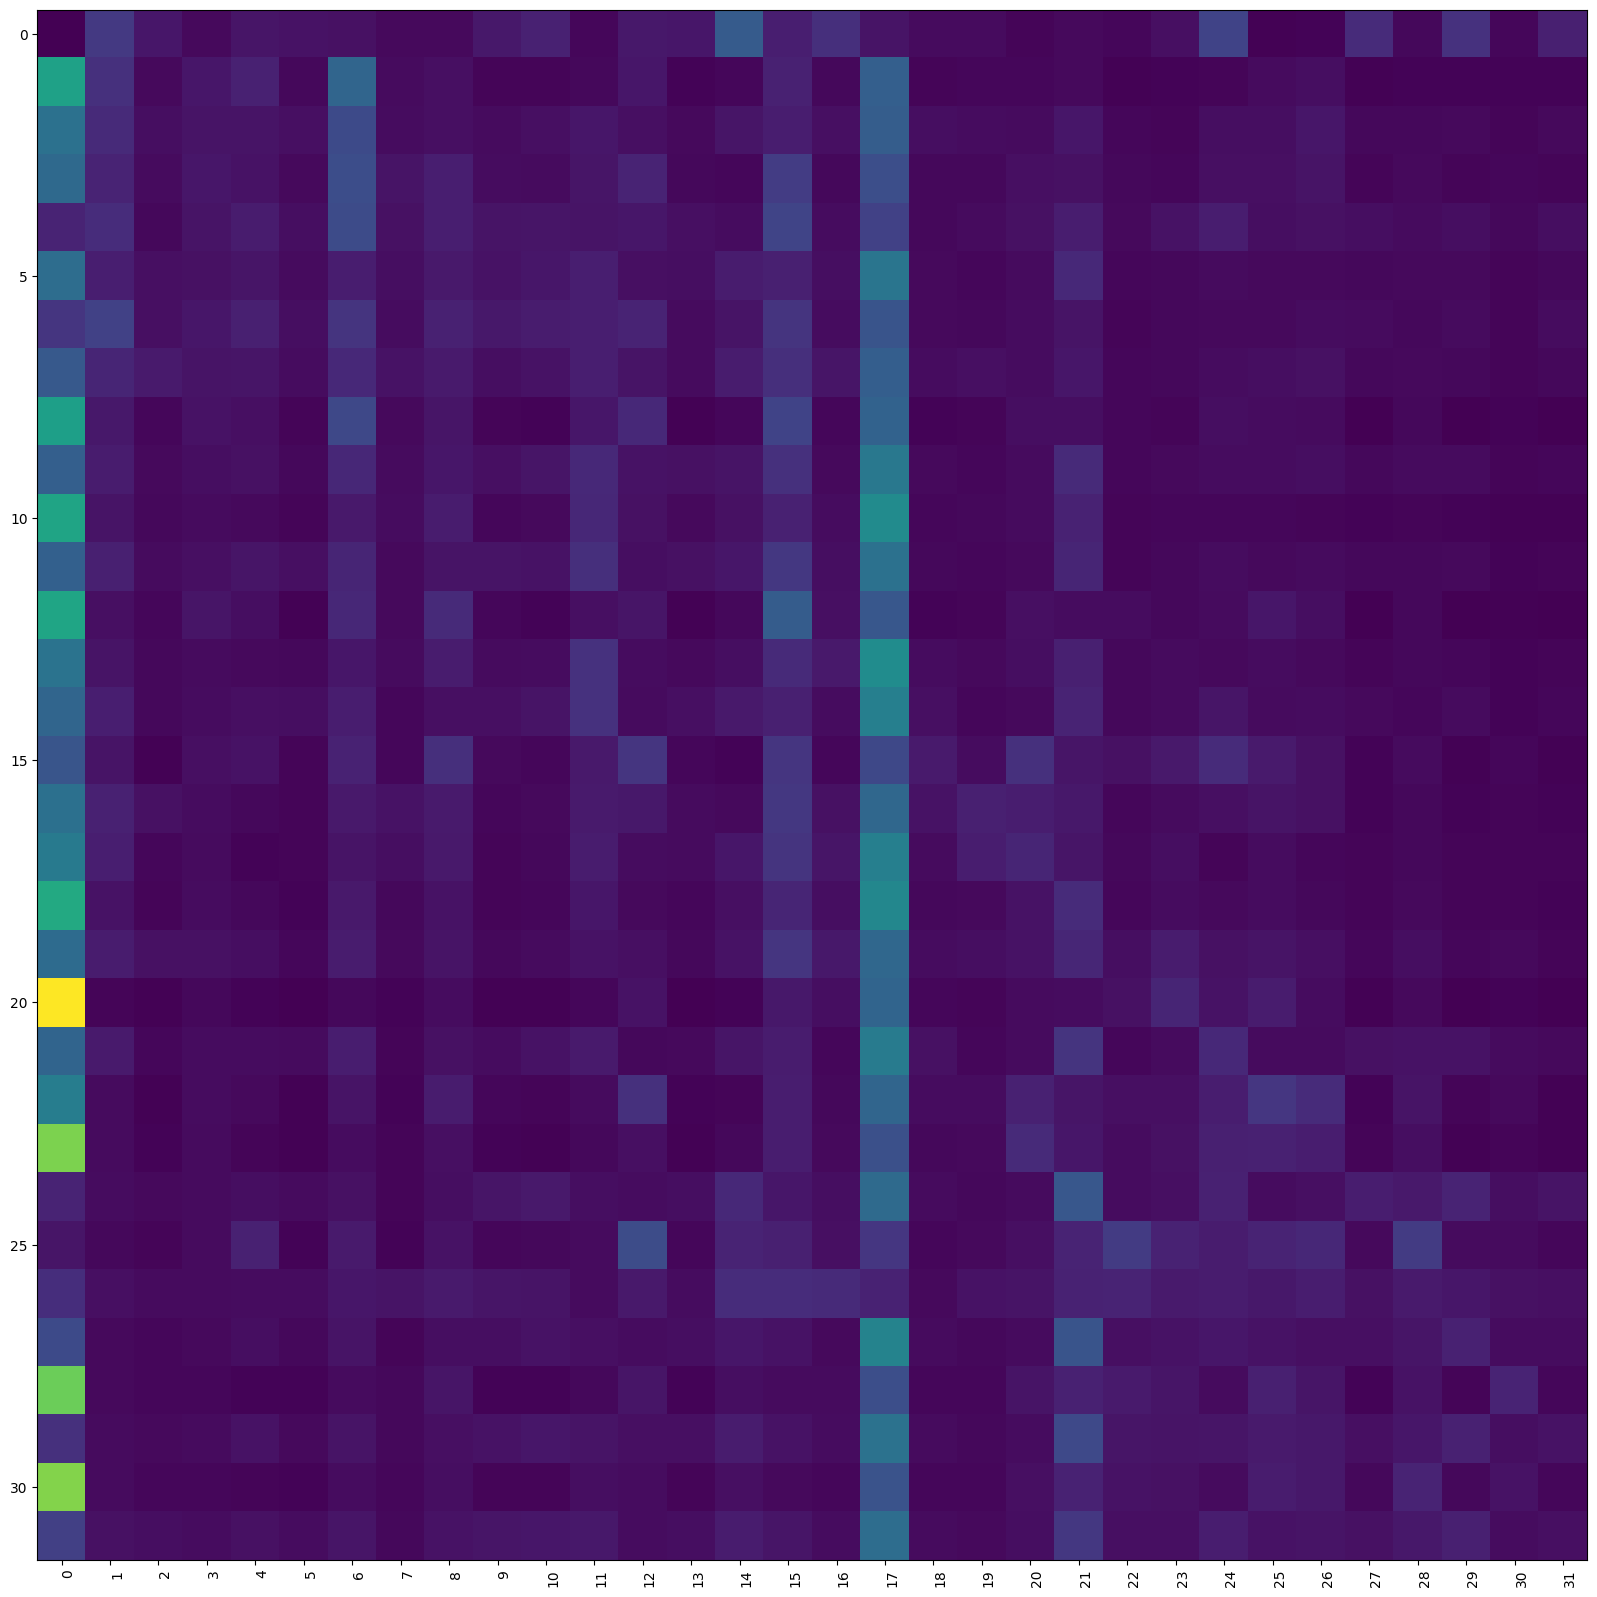

In [94]:
import matplotlib.pyplot as plt

w = model.transformer_blocks[3].attn1.attention_probs
w = w.mean(0)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 30))

# Plot the heatmap
im = ax.imshow(w.detach().cpu().numpy(), cmap='viridis')

# Set ticks on the x-axis for every number
ax.set_xticks(range(w.shape[1]))
ax.set_xticklabels(range(0, w.shape[1])) 
# make tick labels vertical
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Show the plot
plt.show()

In [67]:
src = data_piece[0]["src"]
print(src)
tokenized_src = tokenizer(src)
# token #5 word
tokenizer.convert_ids_to_tokens(tokenized_src["input_ids"][6])

Baked pizza spaghetti Ingredients: 1 pound spaghetti 1 jar pasta sauce of your choice (usually make my own but went lazy on this) 3 cups Italian cheese 1 bag mini pepperoni Directions: -Cook noodles per box directions to aldente or a bit less since they will bake too -[MASK] -Mix pasta and sauce in pot and dump in greased 9x13 pan -Evenly spread cheese on top and top with the mini pepperoni as many or little as you like. -Bake in 375F oven for half a hour or until cheese is nice and brown


'1'

In [93]:
gen = tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True)
print(gen)
print(len(sample_id_tensor[0]))
tokenizer.convert_ids_to_tokens(sample_id_tensor[0][17].cpu().tolist())

['in a large bowl, combine the oil,, and sugar, and reduce the., the orange and zest, baking powder, honey, cinnamon,']
32


'.'

In [86]:
sample_id_tensor[0]

tensor([  101,  1999,  1037,  2312,  4605,  1010, 11506,  1996,  3514,  1010,
         1010,  1998,  5699,  1010,  1998,  5547,  1996,  1012,  1010,  1996,
         4589,  1998, 27838,  3367,  1010, 21522,  9898,  1010,  6861,  1010,
        21229,  1010], device='cuda:3')

In [78]:
tgt = data_piece[0]["tgt"]
print(tgt)
tokenized_tgt = tokenizer(tgt)
tokenizer.convert_ids_to_tokens(tokenized_tgt["input_ids"][14])

In a pan heat sauce with a 1/4 bag pepperoni


'[SEP]'

In [ ]:
range(w.shape[1])

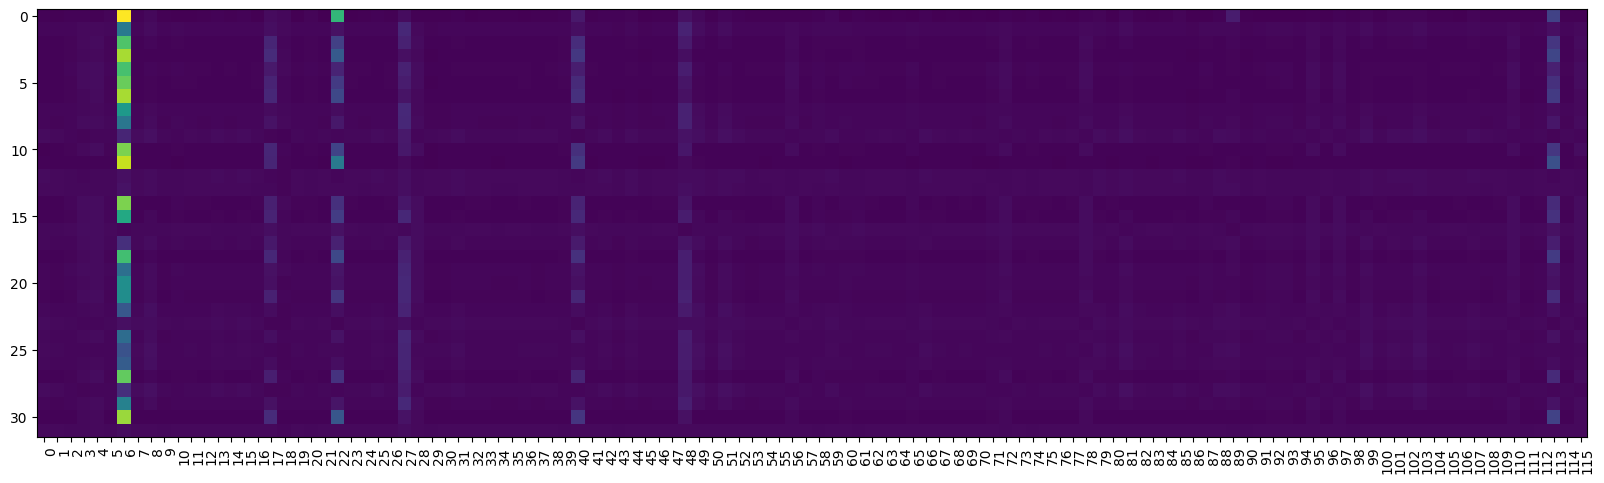

In [26]:
import matplotlib.pyplot as plt

w = model.transformer_blocks[5].attn2.attention_probs
w = w.mean(0)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 30))

# Plot the heatmap
im = ax.imshow(w.detach().cpu().numpy(), cmap='viridis')

# Set ticks on the x-axis for every number
ax.set_xticks(range(w.shape[1]))
ax.set_xticklabels(range(0, w.shape[1])) 
# make tick labels vertical
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Show the plot
plt.show()

In [ ]:
w.shape

In [ ]:
print("Src:", [d["src"] for d in data_piece])
print("Tgt:", [d["tgt"] for d in data_piece])
print("Sample:", each_sample_list)